# 링크 
X-Ray Pneumonia - CNN, Tensorflow 2.0, Keras [94%]  

https://www.kaggle.com/michalbrezk/x-ray-pneumonia-cnn-tensorflow-2-0-keras-94


## Load libraries

In [2]:
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from tensorflow.keras.losses import sparse_categorical_crossentropy

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Load data


In [3]:
path = './input/chest_xray/'
# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'

# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg') #1341
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')#3875

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')#234
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')#390

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')#8
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')#8

In [4]:
# make path using / instead of \\ ... this may be redudant step
train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]


# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])


# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

## Visualize distribution of cases


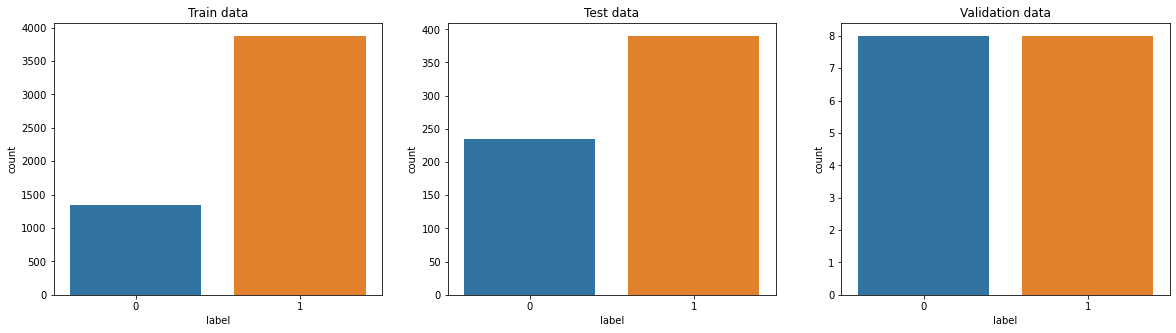

In [5]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_df['label'])
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(test_df['label'])
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val_df['label'])
plt.title('Validation data')

plt.show()

## Data preprocessing_(196,196)
process_data - 이미지 로드, 크기 조정, 그레이스케일로 변환, 정규화 및 텐서 흐름에 필요한 차원으로 재조정  
compose_dataset - 이미지를 반복하여 2 Numpy 배열 생성. 첫째는 이미지 자체를 매트릭스로 포함하며, 둘째는 레이블을 포함함


In [6]:
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (196, 196))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (196,196,1))
    
    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

In [7]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 196, 196, 1), Labels shape: (5216,)
Test data shape: (624, 196, 196, 1), Labels shape: (624,)
Validation data shape: (16, 196, 196, 1), Labels shape: (16,)


In [8]:
# define generator
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)

In [9]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

## Kfold  Cross Validation

In [10]:
kfold = KFold(n_splits=5, shuffle=True)

In [11]:
# Model configuration
img_width, img_height, img_num_channels = 196, 196, 1 #gray image channel = 1
loss_function = sparse_categorical_crossentropy
no_classes = 2
acc_per_fold = []
loss_per_fold = []

## Modelling

In [12]:
def get_model():
    model = Sequential([
        Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(196, 196, 1)),
        Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3,3)),
        
        Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'),
        Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3,3)),
        
        Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        
        Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        
        Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        
        Flatten(),
        Flatten(),
        Dropout(0.2),
        Dense(2, activation='softmax')        
    ])
    
    # compile model
    optimizer = Adam(lr=0.0001, decay=1e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
for i, (train, test) in enumerate(kfold.split(X_train, y_train), 1):
   
    print(f'training model for Kfold #{i}')
    callback = EarlyStopping(monitor='loss', patience=6)
    
    model = get_model()

    # Fit data to model
    #model.fit(datagen.flow(X_train[train], y_train[train], batch_size=4),
    history = model.fit(X_train[train], y_train[train],
                        batch_size = 8,
                        epochs=35,
                        callbacks=[callback],
                        verbose = 1,
                        class_weight={0:6.0, 1:0.5}
                       )
    
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print(f'Score for fold {i}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    #filename = './models/model_cnn' + str(i) + '.h5'
    #model.save(filename)
    #print('>Saved %s' % filename)

training model for Kfold #1
Epoch 1/50
261/261 [==============================] - 167s 638ms/step - loss: 0.8318 - accuracy: 0.3229
Epoch 2/50
261/261 [==============================] - 167s 638ms/step - loss: 0.3315 - accuracy: 0.8353
Epoch 3/50
261/261 [==============================] - 167s 639ms/step - loss: 0.2663 - accuracy: 0.8636
Epoch 4/50
261/261 [==============================] - 168s 643ms/step - loss: 0.2247 - accuracy: 0.8804
Epoch 5/50
261/261 [==============================] - 167s 639ms/step - loss: 0.2066 - accuracy: 0.8938
Epoch 6/50
261/261 [==============================] - 168s 642ms/step - loss: 0.1885 - accuracy: 0.9010
Epoch 7/50
261/261 [==============================] - 168s 642ms/step - loss: 0.1803 - accuracy: 0.9084
Epoch 8/50
261/261 [==============================] - 168s 642ms/step - loss: 0.1669 - accuracy: 0.9144
Epoch 9/50
261/261 [==============================] - 167s 641ms/step - loss: 0.1416 - accuracy: 0.9252
Epoch 10/50
261/261 [===============

261/261 [==============================] - 168s 645ms/step - loss: 0.0437 - accuracy: 0.9777
Epoch 31/50
261/261 [==============================] - 168s 644ms/step - loss: 0.0165 - accuracy: 0.9933
Epoch 32/50
261/261 [==============================] - 168s 643ms/step - loss: 0.0094 - accuracy: 0.9959
Epoch 33/50
261/261 [==============================] - 168s 642ms/step - loss: 0.0406 - accuracy: 0.9832
Epoch 34/50
261/261 [==============================] - 168s 643ms/step - loss: 0.0380 - accuracy: 0.9820
Epoch 35/50
261/261 [==============================] - 168s 644ms/step - loss: 0.0096 - accuracy: 0.9954
Epoch 36/50
261/261 [==============================] - 168s 643ms/step - loss: 0.0106 - accuracy: 0.9950
Epoch 37/50
261/261 [==============================] - 168s 642ms/step - loss: 0.0057 - accuracy: 0.9974
Epoch 38/50
261/261 [==============================] - 168s 642ms/step - loss: 0.0060 - accuracy: 0.9976
Epoch 39/50
261/261 [==============================] - 168s 644ms/s

In [ ]:
# == Provide average scores ==
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')